# Project 2: Supervised Learning
### Building a Student Intervention System

## Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

### _Classification_
A machine learning problem where the learner's objective is to predict a discrete outcome is a classification problem. Here, the objective is to identify students who might need an early intervention, in machine learning terminology a **"binary classification"** problem. More concretely, given the data about a student i.e. the features that describe a student, the learner must be able to classify the student into **"Passed"** or **"Failed"** so that the learner may be used to further aid in deciding whether a student **"Needs an early intervention"** or **"Doesn't"**.

## Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from collections import defaultdict

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data.index)
n_features = len(student_data.columns)-1
n_passed = len(student_data[student_data.passed=="yes"].index)
n_failed = n_students-n_passed
grad_rate = float(n_passed)/n_students
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 0.67%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print
print "Target column: {}".format(target_col)

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed


In [5]:
X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows


Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       yes      yes        no       5         3     3    1    1      3   
2   ...       yes      yes        no       4         3     2    2    3      3   
3   ...       yes      yes       yes       3         2     2    1    1      5   
4   ...       yes       no        no       4         3     2    1    2      5   

  absences  
0        6  
1        4  

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    """
    Function: Change the input categorical features into binary features
            using the pandas get_dummies function
    Params: 
        X: A pandas DataFrame containing the categorical features.
    Returns:
        outX: A pandas DataFrame with dummy variables created 
            in place of categorical features.
    """
    
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

In [7]:
X_all = preprocess_features(X_all) #pre-process features
y_all = y_all.replace(['yes','no'],[1,0]) #pre-process target labels
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train,X_test,y_train,y_test = train_test_split(X_all,y_all,test_size=.24,random_state=42)
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [10]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    """
    Function: Given the instance of a classifier and the training samples,target labels,
            return the trained classifier and the time taken to train the classifier.
    Params:
        clf: Instance of a scikit-learn classifier.
        X_train: The training data to fit the classifier instance with,
                {array-like, sparse matrix}, shape (n_samples, n_features).
        y_train: The target labels to train the classifier instance with,
                array-like, shape (n_samples,)
    Returns:
        clf: The instance of a classifer trained using the training samples and target labels.
        end-start: Time taken to train the classifier.
    """
    
    #print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    return clf,end-start

In [11]:
# TODO: Choose a model, import it and instantiate an object
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

# Fit model to training data
clf,time_taken = train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf # you can inspect the learned model by printing it
print "Training time (secs): {:.3f}".format(time_taken) # time taken to train the classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Training time (secs): 0.203


In [12]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    """
    Function: Given a trained classifier perform classification 
            on samples in features and compute the F1 score and error in classification.
    Params:
        clf: Instance of a scikit-learn trained classifier.
        features: sample dataset to perdict the target labels,
                {array-like, sparse matrix}, shape (n_samples, n_features)
        target: Actual target labels of the sample dataset,
                array-like, shape (n_samples,)
    Returns: 
        end-start: Time taken to predict the target labels using the trained classifier.
        f1_score : metric used to measure the performance of the classifier.
    """
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return end-start,f1_score(target.values, y_pred, pos_label=1)

In [13]:
time_taken,train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {:.3f}".format(train_f1_score)
print "Training set prediction time (secs): {:.3f}".format(time_taken)

F1 score for training set: 0.847
Training set prediction time (secs): 0.001


In [14]:
# Predict on test data
time_taken,test_f1_score = predict_labels(clf, X_test, y_test)
print "F1 score for test set: {:.3f}".format(test_f1_score)
print "Test set precidtion time (secs): {:.3f}".format(time_taken)

F1 score for test set: 0.806
Test set precidtion time (secs): 0.000


In [15]:
# Train and predict
def train_predict(clf, X_train, y_train, X_test, y_test):
    """
    Function: Given the instance of a scikit-learn classifier,
            training and test sets, return a dictionary containing
            the time and F1 score measures on both the sets.
    Params:
        clf: Instance of a scikit-learn classifier.
        X_train: The training data to fit the classifier instance with,
                {array-like, sparse matrix}, shape (n_samples, n_features).
        y_train: The target labels to train the classifier instance with,
                array-like, shape (n_samples,)
        X_test: The test dataset to perdict the target labels,
                {array-like, sparse matrix}, shape (n_samples, n_features)
        y_test: The actual target labels of the test dataset,
                array-like, shape (n_samples,)
    Returns:
        Dict{
            'train_size':*Size of the training set*,
            'train_time':*Time taken to train the classifier*,
            'train_score':*F1 Score, calculated on the training samples* ,
            'test_time':*Time taken to predict on the test set*,
            'test_score':*F1 Score, calculated on the test samples*
            }
    
    """
    clf,train_time = train_classifier(clf, X_train, y_train) #Train the classifier.
    predict_train_time,predict_train_score = predict_labels(clf, X_train, y_train) #Predict on the training set
    predict_test_time,predict_test_score = predict_labels(clf, X_test, y_test) #Predict on the test set.
    return {"Training set size":len(X_train),
            "Training time (secs)":train_time,
            "F1 Score on Training Set":predict_train_score,
            "Prediction time (secs)":predict_test_time,
            "F1 Score on Testing Set":predict_test_score,
           }
# TODO: Run the helper function above for desired subsets of training data

In [16]:
#Retrieve the metrics using different training set sizes
#Note: Keep the test set constant
def get_metrics(clf, X_train, y_train, X_test, y_test):
    """
    Fuction: Computes and returns a DataFrame containing the performance measures
            of the classifier for test set sizes in [100,200,300].
    Params:
        clf: Instance of a scikit-learn classifier.
        X_train: The training data to fit the classifier instance with,
                {array-like, sparse matrix}, shape (n_samples, n_features).
        y_train: The target labels to train the classifier instance with,
                array-like, shape (n_samples,)
        X_test: The test dataset to perdict the target labels,
                {array-like, sparse matrix}, shape (n_samples, n_features)
        y_test: The actual target labels of the test dataset,
                array-like, shape (n_samples,)
    Returns:
        Pandas DataFrame containing the performance metrics of the 
        classifier indexed by the training set size.
    """
    perf = []
    for size in [100,200,300]:
        perf.append(train_predict(clf, X_train[:size], y_train[:size], X_test, y_test))
    return pd.DataFrame.from_records(perf,index="Training set size")

In [17]:
def classifier_perf(clist,X,y,cv=None):
    """
    Function: Train a list if classifiers and return 
        a dictionary of performance metrics.
    Params:
        clist: List of scikit-learn classifier classes.
        X: The samples and features in the dataset,
            {array-like, sparse matrix}, shape (n_samples, n_features).
        y: The target labels in the dataset,
            array-like, shape (n_samples,)
        cv: Instance of a cross-validation generator.
    Return:
        When cv=None:
            clfs: A Dictionary with the classifiers in clist as keys 
                and the performance metrics as a dataframe for each classifier.
        When cv!=None:
            clfs: A Dictionary with the classifiers in clist as keys 
                and the mean performance metrics as a dataframe for each classifier.
            devs: The standard deviations in the performance measure measured across 
                each iteration in the cross-validation
    """
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.24,random_state=18)
    if not cv:
        clfs = {}
        for clf in clist:
            clfs[clf.__class__.__name__] = get_metrics(clf,X_train,y_train,X_test,y_test)
        return clfs
    else:
        clfs = defaultdict(list)
        devs = defaultdict(list)
        for clf in clist:
            for train,test in cv:
                X_train,y_train,X_test,y_test = X.iloc[train],y.iloc[train],X.iloc[test],y.iloc[test]
                clfs[clf.__class__.__name__].append(get_metrics(clf,X_train,y_train,X_test,y_test))
        for clf,perf in clfs.iteritems():
            df = pd.DataFrame()
            for d in perf:
                df = df.append(perf)
            clfs[clf] = df.groupby(df.index).mean()
            devs[clf] = df.groupby(df.index).std()
        return clfs,devs

In [18]:
# Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem.
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clist = [MultinomialNB(),LogisticRegression(),SVC()]

"""
    Fit this model to the training data, try to predict labels 
    (for both training and test sets), and measure the F1 score.
    Repeat this process with different training set sizes (100, 200, 300),
    keeping test set constant.
"""
clfs = classifier_perf(clist,X_all,y_all)

In [19]:
%matplotlib inline
from matplotlib import pylab
def plot_learning_curve(clf,clf_name,devs=None):
    pylab.plot(clf.index,clf["F1 Score on Training Set"],label="F1 Score on Training Set")
    if devs:
        pylab.fill_between(clf.index,clf["F1 Score on Training Set"]-devs[clf_name]["F1 Score on Training Set"],
                          clf["F1 Score on Training Set"]+devs[clf_name]["F1 Score on Training Set"],
                           alpha=0.1,color="r")
    pylab.plot(clf.index,clf["F1 Score on Testing Set"],label="F1 Score on Testing Set")
    if devs:
        pylab.fill_between(clf.index,clf["F1 Score on Testing Set"]-devs[clf_name]["F1 Score on Testing Set"],
                          clf["F1 Score on Testing Set"]+devs[clf_name]["F1 Score on Testing Set"],
                           alpha=0.1,color="r")
    pylab.xlabel("Testing Size")
    pylab.ylabel("F1 Score")
    pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.grid()
    pylab.title("Learning Curve for the classifier: {}".format(clf_name))
    pylab.show()

What is the theoretical O(n) time & space complexity in terms of input size?
What are the general applications of this model? What are its strengths and weaknesses?
Given what you know about the data so far, why did you choose this model to apply?

### Naive Bayes

#### Description
The <u>Naive Bayes</u> classifier is a learning algorithm based on the *Bayes's theorem*. The fundamental idea is to use
**Bayesian reasoning** to identify the most likely of a set of hypotheses. It assumes an underlying
probabilistic distribution and updates the distribution using the probabilities of the outcome of training and
is a _generative_ classifier. It's ***"Naive"*** in that it assumes conditional independence of features.

#### Complexity </br>

##### Space Complexity
>Given n-features and m-classes, the space complexity of a Naive Bayes classifier is roughly O(n\*m).

##### Time Complexity
>Given n-features, k-samples and m-classes, the time complexity of Naive Bayes classifier is roughly

>>for training - O(n\*k + n\*c)

>>for testing - O(n\*k\*c)

#### General Applications
Due to its computational simplicity(~Linear) and independence assumption Naive Bayes classifiers are widely used in a variety of applications that have relatively high dimensional features such as text classification, facial recognition, market segmentation and medical diagnosis.

##### Strength
1. Computationally tractable.
2. Fast learning speed.
3. Simplicity.
4. Independence from dimensionality.

##### Weakness
1. Poor performance when the independence assumption does not hold.
2. Has difficulty with zero-frequency values.
3. Very simple representation doesn't allow for rich hypotheses.

#### Why Naive Bayes ?
Given that the data at hand is high dimensional (~30 features) and has comparatively lesser number of training samples (~300 samples). A **low variance/high bias** classifier such a Naive Bayes should perform well in prediction as it's prone to *avoid overfitting* and is not affected by the _curse of dimensionality_. Further, it's simplicity and fast computational speed makes it a favorable choice due to the limited resource available in terms of computational time.
scikit-learn.naive_bayes.MultinomialNB is suitable for discrete features. Since, most of the features in the dataset is categorical and has been further discretized using dummy variables. 

'MultinimialNB'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.785185,0.744526,0.000142,0.001231
200,0.847682,0.823129,0.000147,0.000789
300,0.797101,0.766667,0.000148,0.000889


For the entire training set the MultinomialNB classifier reports an F1 Score of 0.797 on the testing set


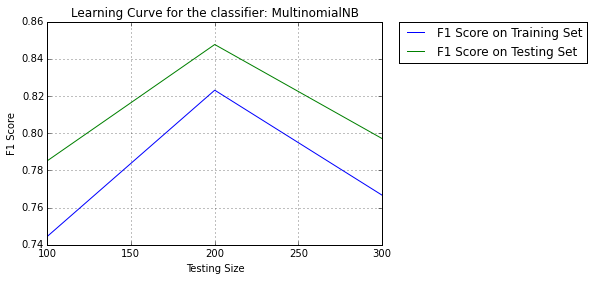

In [20]:
display("MultinimialNB")
display(clfs["MultinomialNB"])
print "For the entire training set the MultinomialNB classifier\
 reports an F1 Score of {:.3f} on the testing set".format(clfs["MultinomialNB"]
                                                                 ["F1 Score on Testing Set"].loc[300])
plot_learning_curve(clfs["MultinomialNB"],"MultinomialNB")

	 	 	
### Support Vector Machine

#### Description

<u>Support Vector Machine</u> (SVM) is a supervised machine learning algorithm that is used for both regression and classification problems. The classifier is best described as a **_large margin classifier_**. The intuition is to plot the features in an n-dimensional space and find a hyperplane that **linearly separates** the classes by optimizing the margin (distance between the hyperplane and the nearest points a.k.a _support vectors_). Since, it works only on linearly separable classes, non-linear hyperplanes are found using ingenious mathematical transformations known as **_"Kernels"_**. This is often referred to as the **"Kernel Trick"**

#### Complexity
A number of factors affect the complexity of the support vector machine algorithm, these include the underlying metric space used to identify the margin, the kernel used and the type of SVM optimizer used.
However, the following is a ballpark reference for non-linear SVMs.

##### Space Complexity
> Given m-samples in the training set, the space complexity is roughly O(n<sup>2</sup>)

##### Time Complexity
> Given m-samples in the training set, the time complexity is roughly O(n<sup>3</sup>)

#### General Applications
Since, SVMs are used where there are complex non-linear hypotheses to be learnt, they are applied in a variety of fields such as Computer Vision, Natural Language Processing, Neuroimaging, Bio-informatics.

##### Strength
1. Flexibility in space, using kernels.
2. Nonlinear functions can be learned with simplicity.
3. Since, it's a large margin classifier we can be certain of the decision boundary margin to be optimum.
4. Good out-of-sample generalization since it only uses the support vectors for classification.

##### Weakness
1. Can be prone to overfitting
2. For very large data sets they have relatively bad performance and can be slow.
3. The performance can be affected when the classes overlap at complicated levels and are noisy.

#### Why SVM ? 
Since the data set is **high dimensional** and we have a **relatively small training set size** SVM seemed like an appropriate choice of learning algorithm. With an **rbf/Gaussian** kernel it is possible to learn non-linear hypotheses and perform relatively well in the classification task. Furthermore, we will be able to tune the margin of the decision boundary using the regularization parameter *_"C"_*. 
scikit-learn.SVM.SVC has been implemented using LIBSVM and is quite efficient in optimization. With the above considerations SVM was chosen as one of the algorithms suitable for the problem given the data and resources.   

'SVM'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.846626,0.823529,0.000910,0.001550
200,0.846626,0.869010,0.001537,0.004141
300,0.835443,0.846491,0.002146,0.008700


For the entire training set the Support Vector Machine classifier reports an F1 Score of 0.835 on the testing set


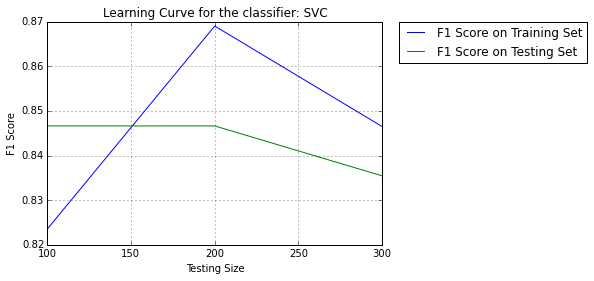

In [21]:
display("SVM")
display(clfs["SVC"])
print "For the entire training set the Support Vector Machine classifier\
 reports an F1 Score of {:.3f} on the testing set".format(clfs["SVC"]
                                                                 ["F1 Score on Testing Set"].loc[300])
plot_learning_curve(clfs["SVC"],"SVC")

### Logistic Regression

#### Description

<u>Logistic Regression</u> despite it's name is a *_stastical model_* that analyzes the relationship between multiple independent variables and a categorical dependent variable to **estimates the probability of the output class** by fitting data to a logistic curve. Although this is method is suitable for binary classification, multivariate classifications can be performed using a technique called **one-vs-all** where multiple models are trained and the class with the highest probability is chosen for output. Since, the model only outputs the probability of a class it's required that the we provide the threshold value that controls the output class.

#### Complexity
The complexity of the model is essentially governed by the optimizer used to solve the optimization of the cost-function. We shall consider the the generalized linear optimiser(Conjugate Gradient) here.

##### Space Complexity
>The space complexity of logistic regression is O(1).

##### Time Complexity
>Given m-samples in the training set, the time complexiy is roughly (less than) O(m).

#### General Applications
Logistic regression is ideally used for any kind of classification and is suitable as long as there is no overlapping of classes. This includes stock market analysis, market segmentation, Optical character recognition and digit recognition.

##### Strength
1. Logistic regression is intrinsically simple and hence a fast learner.
2. It has low variance when regularized and so is less prone to overfitting.
3. The classes need not be normally distributed and need not have equal variance in each class.
4. No linear relationship assumptions need to be made between the independent and dependent variables.

##### Weakness
1. It needs relatively high number of training sample to make reasonable assumptions.
2. It assumes a linear decision boundary and when this assumption is violated it tends to perform badly.

#### Why Logistic Regression ?
Logistic regression is a very simple learning algorithm and yet it is able to estimate complex hypotheses. The ability to do this with very little computational resources and yet arrive at resonable hypotheses is a promising strength of logistic regression that suits the learning problem at hand. Controlling the regularization parameter allows us to find a complexity of the hypotheses. The scikit-learn.linear_model.LogisticRegression is implemented to be quite efficient and with the above considerations Logistic Regression is a suitable algorithm for the given problem and data as it can prove to be cost effective and make reasonable predictions.

'LogisticRegression'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.835616,0.848485,0.000155,0.001071
200,0.818182,0.850340,0.000158,0.002252
300,0.821918,0.826291,0.000163,0.002872


For the entire training set the LogisticRegression classifier reports an F1 Score of 0.822 on the testing set


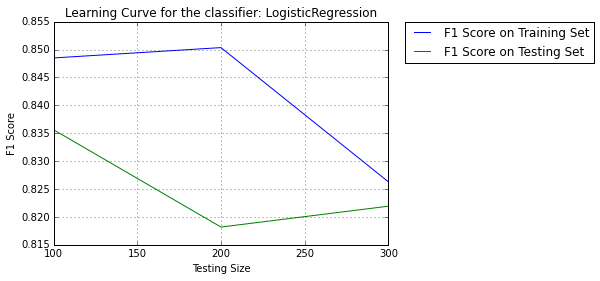

In [22]:
display("LogisticRegression")
display(clfs["LogisticRegression"])
print "For the entire training set the LogisticRegression classifier\
 reports an F1 Score of {:.3f} on the testing set".format(clfs["LogisticRegression"]
                                                                 ["F1 Score on Testing Set"].loc[300])
plot_learning_curve(clfs["LogisticRegression"],"LogisticRegression")

In [23]:
"""
    Produce a table showing training time, prediction time, 
    F1 score on training set and F1 score on test set, for each training set size.
    Note: You need to produce 3 such tables - one for each model.
"""
from IPython.display import display, HTML
for k,v in clfs.iteritems():
    display(k)
    display(v)

'MultinomialNB'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.785185,0.744526,0.000142,0.001231
200,0.847682,0.823129,0.000147,0.000789
300,0.797101,0.766667,0.000148,0.000889


'LogisticRegression'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.835616,0.848485,0.000155,0.001071
200,0.818182,0.850340,0.000158,0.002252
300,0.821918,0.826291,0.000163,0.002872


'SVC'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.846626,0.823529,0.000910,0.001550
200,0.846626,0.869010,0.001537,0.004141
300,0.835443,0.846491,0.002146,0.008700


## Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

### Concerns
The above results are based on only one cross-validation set and it is quite unclear whether the distribution of the training data played a role in the classifier F<sub>1</sub> score. Hence, the experiments are repeated with StratifiedShuffledSplit cross-validation and the mean scores and times across the sets is considered as an appropriate measure to measure the performance of the classifiers.

'MultinomialNB'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.760062,0.808661,0.000147,0.000757
200,0.761203,0.793698,0.000149,0.000727
300,0.770446,0.792415,0.000149,0.000752


/home/bharat/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


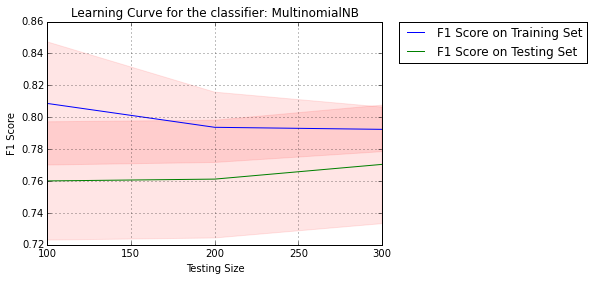

'LogisticRegression'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.745783,0.892038,0.000157,0.001094
200,0.763652,0.847920,0.000157,0.001998
300,0.774074,0.836411,0.000162,0.002853


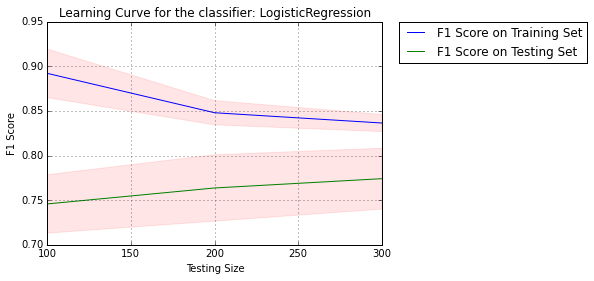

'SVC'

,F1 Score on Testing Set,F1 Score on Training Set,Prediction time (secs),Training time (secs)
Training set size,,,,
100,0.795640,0.868331,0.000827,0.001345
200,0.803633,0.869557,0.001438,0.003816
300,0.802467,0.868864,0.001952,0.007767


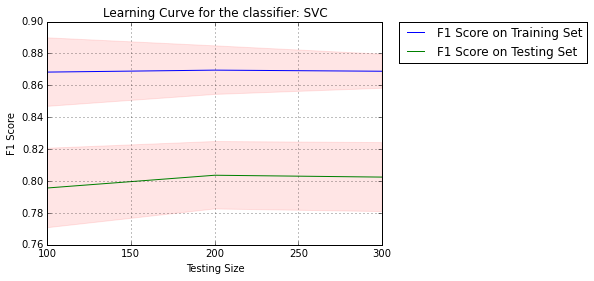

In [24]:
from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(y_all, n_iter=30, test_size=0.24, random_state=42)
cvlist = [MultinomialNB(),LogisticRegression(),SVC()]
clfs,devs = classifier_perf(cvlist,X_all,y_all,cv=cv)
for k,v in clfs.iteritems():
    display(k)
    display(v)
    plot_learning_curve(v,k,devs)

### Further Graphical Comparision of Classifiers

In [25]:
%matplotlib inline
from matplotlib import pylab
def plotClfCompare(clfs,devs=None,**kwargs):
    if kwargs is not None:
        wmap =  {"test_score":"F1 Score on Testing Set",
                "train_score":"F1 Score on Training Set",
                "predict_time":"Prediction time (secs)",
                "train_time":"Training time (secs)"}
        for metric in [wmap[key] for key,value in kwargs.items() if value]:
            for key,value in clfs.items():
                pylab.plot(value.index,value[metric],label=key)
                pylab.xlabel(value.index.name)
                pylab.ylabel(value[metric].name)
                pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                pylab.grid()
                title = "".join([value.index.name," vs ",value[metric].name])
                pylab.title(title)
                if devs:
                    pylab.fill_between(value.index, value[metric] - devs[key][metric],
                                       value[metric] + devs[key][metric], alpha=0.1,color="r")
            pylab.show()

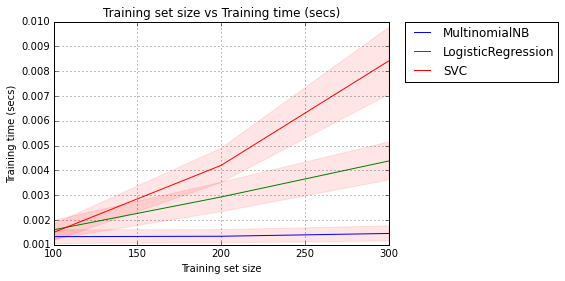

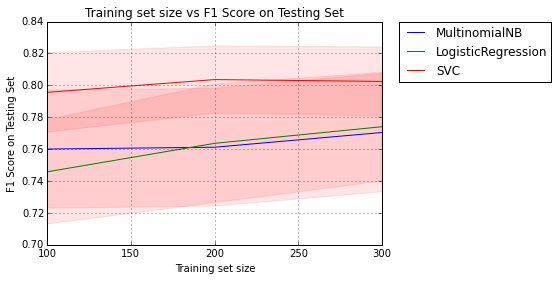

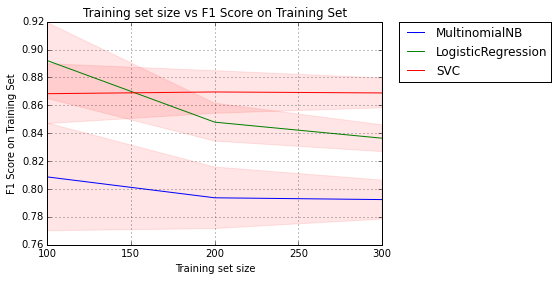

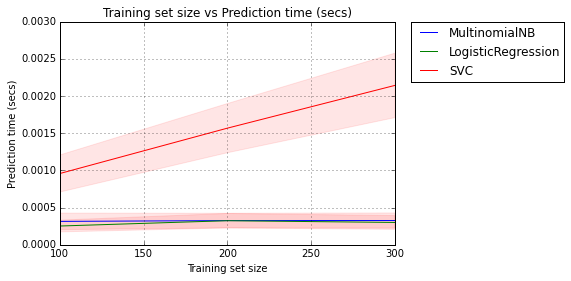

In [26]:
cv = StratifiedShuffleSplit(y_all, n_iter=30, test_size=0.24, random_state=42)
cvlist = [MultinomialNB(),LogisticRegression(),SVC()]
clfs,devs = classifier_perf(cvlist,X_all,y_all,cv=cv)
plotClfCompare(clfs,devs,test_score =True,train_score=True, 
               predict_time=True,train_time=True)

The model is evaluated on **_three factors_**:

1. Its **F<sub>1</sub> score**, summarizing the number of correct positives and correct negatives out of all possible cases. In other words, how well does the model differentiate likely passes from failures?
    - From the above three classifier tables it's quite clear that SVMs have a better F<sub>1</sub> score over the other models for the available dataset.
    
2. The **size of the training set**, preferring smaller training sets over larger ones. That is, how much data does the model need to make a reasonable prediction?
    - While SVMs need relatively small training sets to learn complicated functions, Naive Bayes and Logistic Regression need larger datasets to start making reasonable predictions.
 
3. The **computation resources** to make a reliable prediction. How much time and memory is required to correctly identify students that need intervention?
    - While SVMs need smaller training sets, they are awfully expensive in terms of computation cost both time and space when compared to the logistic regression and Naive Bayes classifiers.
    
While all this points to **SVM** as a suitable model, the cost is a concern, it is believed that the **LogisticRegression** model can perform better at a lower cost provided we are able to find the right hyperparameters.
Hence we shall proceed with using the **LogisticRegression** model.

### Logistic Regression

As discussed earlier logistic regression is a _linear statistical model_. The intuition behind the model is to find a linear decision boundary that classifies the data whilst minimizing the error in the classification. The model makes predictions by first finding a linear equation using the independent variable. The linear equation is then used in the **_sigmoid/logistic_** function to find the probability of the class that a data point belongs to. Since, the model is probabilistic in its output, it is required that we define a threshold value of probability for the model to make an actual prediction. In the case of the student intervention system, 0.50 seems appropriate because if there is even a 0.50 chance that a student might not pass it's justifiable to provide the student with the necessary support to graduate.

In logistic regression an hyperparameter called the **regularization parameter** **(_C_)** can be used to control the complexity of the model. The complexity affects the bias/variance tradeoff and hence we shall use the GridSearchCV algorithm to find the optimal value of **_C_** that results in the right tradeoff between the bias and variance of the model. Futher the **_C_** shall be searched using the **_l<sub>1</sub>_** and **_l<sub>2</sub>_** that defines how to deal with sparse and correlated predictors.

In [27]:
params = {"C":np.linspace(0.001,1,200),"penalty":["l1","l2"],"solver":["liblinear"]}
clf = LogisticRegression(random_state=42)
cv = StratifiedShuffleSplit(y_all,n_iter=25,test_size=0.24)
from sklearn.grid_search import GridSearchCV

In [28]:
gclf = GridSearchCV(clf,param_grid=params,scoring="f1",cv=cv,n_jobs=4)
gclf.fit(X_all,y_all)

/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bharat/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[0 0 ..., 1 0], n_iter=25, test_size=0.24, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.001  ,  0.00602, ...,  0.99498,  1.     ]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [29]:
print gclf.best_params_

{'penalty': 'l1', 'C': 0.081321608040201013, 'solver': 'liblinear'}


### The final f<sub>1</sub> score of the model is:

In [30]:
print "F1 Score: {:.3f}".format(gclf.best_score_)

F1 Score: 0.824
